# Notebook 5 - Finding cloud frequency using spectral thresholds

Using Notebook 4 (goes_eval_w_camera), we have found a combination of thresholds using a decision tree to identify cloudy vs. clear pixels in GOES data.

In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

/home/cdalden/miniforge3/envs/goes_env/lib/python3.13/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


### Load in rgb composite files

In [10]:
for day in range(13, 32):    
    date = '202207' + str(day).zfill(2)
    path = '/storage/cdalden/goes/washington/goes17/rgb_composite/'
    file = 'goes17_C02_C05_C13_rgb_washington_{date}.nc'.format(date=date)

    ds = xr.open_dataset(path + file)

    # Make mask for cloud/no cloud
    clouds = xr.where((ds.green >= 0.15) & (ds.red >= 0) & (ds.blue >= 0.13), 1, 0) # cloud (1) if all conds are met, not cloud (0) otherwise
    ds['clouds'] = clouds

    # Select the time range between 0000-0300 and 1400-2359
    cloud_frequency = ds.clouds.sel(
        t=((ds['t'].dt.hour >= 0) & (ds['t'].dt.hour < 3)) | (ds['t'].dt.hour >= 14)
    ).sum(dim='t')
    cloud_counts = xr.Dataset(
        {'cloud_frequency': (['latitude', 'longitude'], cloud_frequency.data)},
        coords={'latitude': ds.latitude, 'longitude': ds.longitude}
    )

    # Save the cloud frequency data to a NetCDF file
    out_path = '/storage/cdalden/goes/washington/goes17/cloud_counts/'
    out_file = 'goes17_cloud_frequency_washington_{date}.nc'.format(date=date)
    cloud_counts.to_netcdf(out_path + out_file)
    print(f"Processed and saved cloud frequency for {date}")

Processed and saved cloud frequency for 20220713
Processed and saved cloud frequency for 20220714
Processed and saved cloud frequency for 20220715
Processed and saved cloud frequency for 20220716
Processed and saved cloud frequency for 20220717
Processed and saved cloud frequency for 20220718
Processed and saved cloud frequency for 20220719
Processed and saved cloud frequency for 20220720
Processed and saved cloud frequency for 20220721
Processed and saved cloud frequency for 20220722
Processed and saved cloud frequency for 20220723
Processed and saved cloud frequency for 20220724
Processed and saved cloud frequency for 20220725
Processed and saved cloud frequency for 20220726
Processed and saved cloud frequency for 20220727
Processed and saved cloud frequency for 20220728
Processed and saved cloud frequency for 20220729
Processed and saved cloud frequency for 20220730
Processed and saved cloud frequency for 20220731


## Combine daily data into 1 month

In [15]:
month = '07'
# Define the date range and file path
path = '/storage/cdalden/goes/washington/goes17/cloud_counts/'
file_template = 'goes17_cloud_frequency_washington_{date}.nc'

# Generate the list of file paths and corresponding times
file_paths = []
times = []
for day in range(13, 32):  # Days 1 to 30
    date = f'2022{month}{str(day).zfill(2)}'  # Format the date as '202209DD'
    file_paths.append(path + file_template.format(date=date))
    times.append(pd.Timestamp(f'2022-{month}-{str(day).zfill(2)}'))  # Create a timestamp for each day

# Open all files and add the time dimension
datasets = []
for file, time in zip(file_paths, times):
    ds = xr.open_dataset(file)
    ds = ds.expand_dims(time=[time])  # Add the time dimension
    datasets.append(ds)

# Combine all datasets along the time dimension
combined_ds = xr.concat(datasets, dim='time')

# Compute the sum across the time dimension
monthly_sum = combined_ds['cloud_frequency'].sum(dim='time')

# Add the monthly sum as a new variable to the dataset
combined_ds['monthly_sum'] = monthly_sum

# monthly frequency 
combined_ds['monthly_frequency'] = combined_ds['monthly_sum'] / (156*30)  # Assuming 156 observations per day for 30 days

combined_ds.to_netcdf(path + f'goes17_monthly_cloud_frequency_washington_2022{month}.nc')


In [16]:
jul_cloud_freq = xr.open_dataset(path + 'goes17_monthly_cloud_frequency_washington_202207.nc')
aug_cloud_freq = xr.open_dataset(path + 'goes17_monthly_cloud_frequency_washington_202208.nc')
sep_cloud_freq = xr.open_dataset(path + 'goes17_monthly_cloud_frequency_washington_202209.nc')

sep_minus_aug = sep_cloud_freq.monthly_frequency - aug_cloud_freq.monthly_frequency

In [17]:
sep_minus_aug

<xarray.DataArray 'monthly_frequency' (latitude: 251, longitude: 487)> Size: 978kB
array([[-0.06602564, -0.06388889, -0.06239316, ...,  0.02542735,
         0.0241453 ,  0.02521368],
       [-0.06602564, -0.06388889, -0.06239316, ...,  0.02222222,
         0.0241453 ,  0.01260684],
       [-0.06602564, -0.06239316, -0.06239316, ...,  0.0241453 ,
         0.01260684,  0.01260684],
       ...,
       [-0.01282051, -0.00534188, -0.0025641 , ...,  0.01901709,
         0.02200855,  0.01858974],
       [-0.00576923, -0.00534188, -0.0025641 , ...,  0.01623932,
         0.01623932,  0.02051282],
       [ 0.00662393,  0.00662393, -0.0025641 , ...,  0.02564103,
         0.01623932,  0.01816239]])
Coordinates:
  * latitude   (latitude) float64 2kB 49.0 49.0 48.99 48.99 ... 48.01 48.0 48.0
  * longitude  (longitude) float64 4kB -124.0 -124.0 -124.0 ... -121.0 -121.0

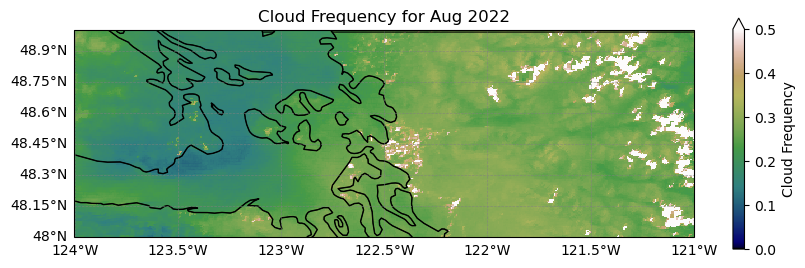

In [24]:
# Create the plot with Cartopy projection
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())  # Use PlateCarree for geographic data

# Plot the data
aug_cloud_freq.monthly_frequency.plot(
    ax=ax, 
    cmap="gist_earth",  
    transform=ccrs.PlateCarree(),  # Specify the data's coordinate system
    cbar_kwargs={'label': 'Cloud Frequency', 'shrink': 0.5},
    vmin=0, vmax=0.5  # Set color scale limits
)

# Add state outlines and coastlines
ax.add_feature(cfeature.COASTLINE, linewidth=1, edgecolor='black')
ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor='black')
# Add gridlines with latitude and longitude labels
gridlines = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.7, linestyle='--')
gridlines.top_labels = False  # Disable top labels
gridlines.right_labels = False  # Disable right labels
gridlines.xlabel_style = {'size': 10, 'color': 'black'}
gridlines.ylabel_style = {'size': 10, 'color': 'black'}


# Add title and labels
plt.title(f"Cloud Frequency for Aug 2022")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()

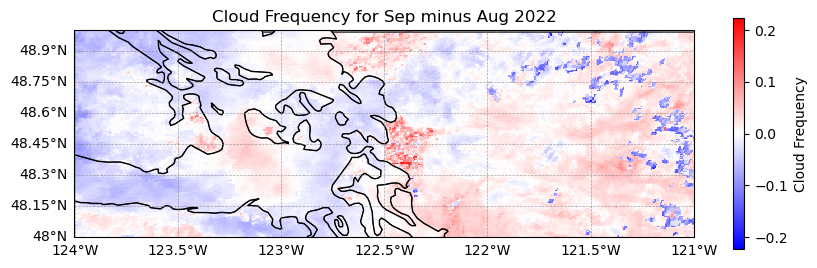

In [18]:
# Create the plot with Cartopy projection
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())  # Use PlateCarree for geographic data

# Plot the data
sep_minus_aug.plot(
    ax=ax, 
    cmap="bwr",  
    transform=ccrs.PlateCarree(),  # Specify the data's coordinate system
    cbar_kwargs={'label': 'Cloud Frequency', 'shrink': 0.5}
)

# Add state outlines and coastlines
ax.add_feature(cfeature.COASTLINE, linewidth=1, edgecolor='black')
ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor='black')
# Add gridlines with latitude and longitude labels
gridlines = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.7, linestyle='--')
gridlines.top_labels = False  # Disable top labels
gridlines.right_labels = False  # Disable right labels
gridlines.xlabel_style = {'size': 10, 'color': 'black'}
gridlines.ylabel_style = {'size': 10, 'color': 'black'}


# Add title and labels
plt.title(f"Cloud Frequency for Sep minus Aug 2022")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()